# Procrastinate Pro+: analysis of the advertising placement effectiveness

**Project description.**

There is an entertainment app Procrastinate Pro+. Despite huge investments in advertising, the company has been losing money for the past few months. 

**The main goal:** to identify the causes of losing money and to give recommendations how to improve the situation.

These is a data about users attracted from May 1 to October 27, 2019. It is now November 1, 2019, and the business plan states that users should pay off no later than two weeks after the acquisition.

**Server log with data about visits:** visits_info_short.csv:
* User Id - unique user ID,
* Region user's country,
* Device — user's device type,
* Channel — source id,
* Session Start — session start date and time,
* Session End — session end date and time.

**Data about purchases:** orders_info_short.csv:
* User Id - unique user ID,
* Event Dt — purchase date and time,
* Revenue — order price.

**Data about advertising costs:** costs_info_short.csv:
* dt — date of advertising campaign,
* Channel — source id,
* costs — ad costs.

**Main questions:**
* where users come from and what devices they use,
* how much it costs to attract users from various advertising channels,
* how much money each client brings,
* when the cost of attracting a client pays off,
* what factors prevent of attracting customers.

### Loading and preparing data

In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# reading files
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

# setting columns names
visits = visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device', 'Channel': 'channel', 
                                'Session Start': 'session_start', 'Session End': 'session_end'})
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})
costs.columns = costs.columns.str.lower()

# converting the time to the correct format
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# creating month and week variables for costs analysis
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

In [3]:
# examining data about visits
visits.info()
print()
print('Duplicates amount', visits.duplicated().sum())
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB

Duplicates amount 0


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
# examining orders data
orders.info()
print()
print('Duplicates amount', orders.duplicated().sum())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB

Duplicates amount 0


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [5]:
# examining costs data
costs.info()
print()
print('Duplicates amount', costs.duplicated().sum())
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   object        
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
 3   month    1800 non-null   datetime64[ns]
 4   week     1800 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(1), object(2)
memory usage: 65.2+ KB

Duplicates amount 0


,dt,channel,costs,month,week
0,2019-05-01,FaceBoom,113.3,2019-05-01,18
1,2019-05-02,FaceBoom,78.1,2019-05-01,18
2,2019-05-03,FaceBoom,85.8,2019-05-01,18
3,2019-05-04,FaceBoom,136.4,2019-05-01,18
4,2019-05-05,FaceBoom,122.1,2019-05-01,18


**CONCLUSIONS**

* We've read the data, renamed the columns, and converted the date and time data to the correct format.
* There are no gaps.
* There are no duplicates.

### Writing functions for calculating and analyzing LTV, ROI, retention and conversion

These are the functions for calculating metric values:

- `get_profiles()` - to create user profiles,
- `get_retention()` - to calculate the Retention Rate,
- `get_conversion()` - to calculate the conversion,
- `get_ltv()` - to calculate LTV.

As well as functions for plotting graphs:

- `filter_data()` - for data smoothing,
- `plot_retention()` - for plotting the Retention Rate graph,
- `plot_conversion()` - for plotting a conversion graph,
- `plot_ltv_roi` - for visualizing LTV and ROI.

#### Functions for calculation

In [6]:
# function for creating user profiles

def get_profiles(visits, orders, ad_costs):

    # finding data on first visits
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'region': 'first',
                'device': 'first',
                'channel': 'first',
                'session_start': 'first'
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    # determining date and month of the first visit
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # adding a sign of users who made a payment
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'])

    # calculating the amount of unique users with the same date and channel
    new_users = (
        profiles.groupby(['channel', 'dt'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'users_count'})
        .reset_index()
    )

    # adding ad costs to the list of unique users
    ad_costs = ad_costs.merge(new_users, on=['channel', 'dt'], how='left')

    # calculating spends on one user acqisition
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['users_count']

    # adding costs to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on = ['dt', 'channel'], how='left'
    )

    # Filling with zeros the cost of users on whom money has not been spent
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [7]:
# fuction for the retention calculation

def get_retention(profiles, visits, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # adding payer to dimensions list
    dimensions = ['payer'] + dimensions

    # excluding users who are not in the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # adding sessions data
    result_raw = result_raw.merge(visits[['user_id', 'session_start']], on='user_id', how='left')

    # calculating the lifetime
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    # function for grouping by desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    # building the retention table
    result_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # building the retention dynamics table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # returning the tables
    return result_raw, result_grouped, result_in_time

In [8]:
# function for conversion calculation

def get_conversion(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # excluding users who are not in the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determining the date and time of the first purchase of each user
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # adding the purchases data to the profiles
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')

    # calculating the lifetime
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    # if the are no dimensions, grouping by cogort
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
    # function for grouping by desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # getting the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # for the conversion dynamics table, removing cohort from dimensions
    if 'cohort' in dimensions:
        dimentions = []

    # getting the conversion dynamics table
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # returning the tables
    return result_raw, result_grouped, result_in_time

In [9]:
# function for LTV and ROI calculation

def get_ltv(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # excluding users who are not in the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # adding the purchases data to the profiles
    result_raw = result_raw.merge(orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')

    # calculating the lifetime
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    # if the are no dimensions, grouping by cogort
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # function for grouping by desired features
    def group_by_dimensions(df, dims, horizon_days):
        # building the revenue triangular table
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        # calculating the revenue with the accumulation
        result = result.fillna(0).cumsum(axis=1)
        # calculating cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # combine cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculating LTV
        result = result.div(result['cohort_size'], axis=0)
        # excluding lifetimes that exceed the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restoring cohort sizes
        result['cohort_size'] = cohort_sizes

        # collecting the dataframe with the users data and CAC
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        # calculating average CAC by dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculating ROI
        roi = result.div(cac['cac'], axis=0)

        # deleting the strings with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # restoring cohort sizes
        roi['cohort_size'] = cohort_sizes
        
        # adding CAC to ROI table
        roi['cac'] = cac['cac']

        # in the final table, leaving the cohort sizes, CAC and ROI
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # returning LTV and ROI tables
        return result, roi
    
    # getting LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # for the dynamics tables, removing cohort from dimensions
    if 'cohort' in dimensions:
        dimensions = []
    
    # getting LTV and ROI dynamics table
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw, # row data
        result_grouped, # LTV table
        result_in_time, # LTV dynamics table
        roi_grouped, # ROI table
        roi_in_time # ROI dynamics table
    )

#### Functions for the visualization

In [10]:
# function for the frame smoothing

def filter_data(df, window):
    # for each column, applying the moving average
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [11]:
# function for the retention visualization

def plot_retention(retention, retention_history, horizon, window=7):

    # setting the grid size for charts
    plt.figure(figsize=(15, 10))

    # eliminating cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])

    # in the table of dynamics, leaving only the necessary lifetime
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon-1]]

    # if there is only payer in the table indexes, adding the second sign - cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
    
    # there are four cells in the graphs table
    # in the first cell, building retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Paying users retention')

    # in the second cell, building retention curves for non-paying users
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Non-paying users retention')

    # in the third cell, building retention dynamics for paying users
    ax3 = plt.subplot(2, 2, 3)
    # getting the columns names for a pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filtering data and building a graph
    filtered_data = retention_history.query('payer == True').pivot_table(
        index = 'dt', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('Paying users retention dynamics on the {}st/nd day'.format(horizon))

    # in the fourth cell, building retention dynamics for non-paying users
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filtering data and graph building
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title('Non-paying users retention dynamics on the {}st/nd day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [12]:
# function for the conversion visualization

def plot_conversion(conversion, conversion_dynamics, horizon, window=7):

    # setting the grid size for charts
    plt.figure(figsize=(15, 5))

    # eliminating cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])

    # in the table of dynamics, saving only the necessary lifetime
    conversion_dynamics = conversion_dynamics.drop(columns=['cohort_size'])[[horizon - 1]]

    # the first graph is about conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Users conversion')

    # the second graph in about conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in conversion_dynamics.index.names if name not in ['dt']]
    filtered_data = conversion_dynamics.pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Acquisition date')
    plt.title('Conversion dynamics on the {}st/nd day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [13]:
# function for the ROI and LTV visualization

def plot_ltv_roi(ltv, ltv_dynamics, roi, roi_dynamics, horizon, window=7):

    # setting the grid size for charts
    plt.figure(figsize=(20, 10))

    # eliminating cohort sizes
    ltv = ltv.drop(columns=['cohort_size'])

    # in the LTV dynamics table, saving only the necessary lifetime
    ltv_dynamics = ltv_dynamics.drop(columns=['cohort_size'])[[horizon - 1]]

    # printing the acquisition cost to a separate frame
    cac_history = roi_dynamics[['cac']]

    # from the ROI table, excluding cohort sizes ans CAC
    roi = roi.drop(columns=['cohort_size', 'cac'])

    # in the ROI dynamics table saving only the necessary lifetime
    roi_dynamics = roi_dynamics.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # building the first graph: LTV curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # building the second graph: LTV dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # the columns of the pivot table are the all columns of the index except the date
    columns = [name for name in ltv_dynamics.index.names if name not in ['dt']]
    filtered_data = ltv_dynamics.pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('LTV dynamics on the {}st/nd day'.format(horizon))

    # building the third graph: CAC dynamics
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # the columns of the pivot table are the all columns of the index except the date
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('Acquisition costs dynamics')

    # building the fourth graph: ROI curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # building the fifth graph: ROI dynamics
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # the columns of the pivot table are the all columns of the index except the date
    columns = [name for name in roi_dynamics.index.names if name not in ['dt']]
    filtered_data = roi_dynamics.pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Acquisition date')
    plt.title('ROI dynamics on the {}st/nd day'.format(horizon))

    plt.tight_layout()
    plt.show()

### EDA

**Tasks:**
- To create user profiles. To determine the minimum and maximum user acquisition dates.
- To find out from which countries users come to the app and which country has the most paying users. To construct a table showing the number of users and share of paying from each country.
- To find out what devices customers use and what devices paying users prefer. To build a table showing the number of users and share of paying for each device.
- Tp study advertising sources of attraction and determine the channels from which the most paying users came. To build a table showing the number of users and share of paying for each acquisition channel.

#### Creating users profiles

In [14]:
# creating profiles
profiles = get_profiles(visits, orders, costs)
print(profiles.head())
print('')

# looking at the minimum and the maximum user acquisition dates
print('Min date: {}'.format(profiles['dt'].min()))
print('Max date: {}'.format(profiles['dt'].max()))

    user_id         region  device     channel            first_ts  \
0    599326  United States     Mac    FaceBoom 2019-05-07 20:58:57   
1   4919697  United States  iPhone    FaceBoom 2019-07-09 12:46:07   
2   6085896         France  iPhone     organic 2019-10-01 09:58:33   
3  22593348        Germany      PC  AdNonSense 2019-08-22 21:35:48   
4  31989216  United States  iPhone     YRabbit 2019-10-02 00:07:44   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  

Min date: 2019-05-01
Max date: 2019-10-27


**CONCLUSION:**
* Dates match those specified in the description.

#### Analysis by countries

In [15]:
# creating the table by countries
regions = (
    profiles.groupby('region')
    .agg({'user_id': 'count', 'payer': 'sum'})
    .reset_index()
    .rename(columns={'user_id': 'users_all', 'payer': 'users_paying'})
)
regions['share_of_paying'] = regions['users_paying'] / regions['users_all']
regions['users_all_%'] = regions['users_all'] / regions['users_all'].sum()
regions['users_paying_%'] = regions['users_paying'] / regions['users_paying'].sum()
regions.sort_values(by='users_paying', ascending=False)

,region,users_all,users_paying,share_of_paying,users_all_%,users_paying_%
3,United States,100002,6902,0.069019,0.666644,0.777165
2,UK,17575,700,0.039829,0.117160,0.078820
0,France,17450,663,0.037994,0.116327,0.074654
1,Germany,14981,616,0.041119,0.099868,0.069362


**CONCLUSIONS:**

* Two-thirds of users are from the USA. The US also has the highest percentage of paying users, so 77% of all paying users are from the US.
* Germany is in second place in terms of the share of paying users, but due to the low total number of users, the number of paying users from Germany is also low.
* From the UK and France, there are about the same number of users, and the share of paying in the UK is slightly higher than in France.
* In general, there is not a very big difference between Germany, France and the UK in terms of the share of paying users.

#### Analysis by device

In [16]:
devices = (
    profiles.groupby('device')
    .agg({'user_id': 'count', 'payer': 'sum'})
    .reset_index()
    .rename(columns={'user_id': 'users_all', 'payer': 'users_paying'})
)
devices['share_of_paying'] = devices['users_paying'] / devices['users_all']
devices['users_all_%'] = devices['users_all'] / devices['users_all'].sum()
devices['users_paying_%'] = devices['users_paying'] / devices['users_paying'].sum()
devices.sort_values(by='users_paying', ascending=False)

,device,users_all,users_paying,share_of_paying,users_all_%,users_paying_%
3,iPhone,54479,3382,0.062079,0.363174,0.380813
0,Android,35032,2050,0.058518,0.233534,0.230830
1,Mac,30042,1912,0.063644,0.200269,0.215291
2,PC,30455,1537,0.050468,0.203023,0.173066


**CONCLUSIONS:**

* The largest number of users (both all and paying) - from iPhone. Android gets the second place.
* The highest share of paying users is on Mac and iPhone. The lowest is on PC.
* Due to low conversion rates, PC has the fewest paying users.

#### Analysis by channels

In [17]:
channels = (
    profiles.groupby('channel')
    .agg({'user_id': 'count', 'payer': 'sum'})
    .reset_index()
    .rename(columns={'user_id': 'users_all', 'payer': 'users_paying'})
)
channels['share_of_paying'] = channels['users_paying'] / channels['users_all']
channels['users_all_%'] = channels['users_all'] / channels['users_all'].sum()
channels['users_paying_%'] = channels['users_paying'] / channels['users_paying'].sum()
channels.sort_values(by='share_of_paying', ascending=False)

,channel,users_all,users_paying,share_of_paying,users_all_%,users_paying_%
1,FaceBoom,29144,3557,0.122049,0.194283,0.400518
0,AdNonSense,3880,440,0.113402,0.025865,0.049544
9,lambdaMediaAds,2149,225,0.104700,0.014326,0.025335
6,TipTop,19561,1878,0.096007,0.130400,0.211463
5,RocketSuperAds,4448,352,0.079137,0.029652,0.039635
7,WahooNetBanner,8553,453,0.052964,0.057017,0.051008
8,YRabbit,4312,165,0.038265,0.028745,0.018579
3,MediaTornado,4364,156,0.035747,0.029092,0.017566
2,LeapBob,8553,262,0.030633,0.057017,0.029501
4,OppleCreativeMedia,8605,233,0.027077,0.057364,0.026236


**CONCLUSIONS:**

* Over 60% of paying users come from FaceBoom and TipTop.
* More users go from FaceBoom than from other sites, while the conversion is the highest.
* High conversion also on TipTop, AdNonSense and lambdaMediaAds sites. At the same time, a small number of people pass from the last two.
* LeapBob, OppleCreativeMedia, YRabbit, MediaTornado sites have low conversion rates.
* More than a third of users come to the application organically, but only 2% of them pay.

#### Looking at the dynamics of the number of new users by country and the share of organic

/tmp/ipykernel_31/1468027507.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_report['share_organic'] = filtered_report['users_organic'] / filtered_report['users_all']


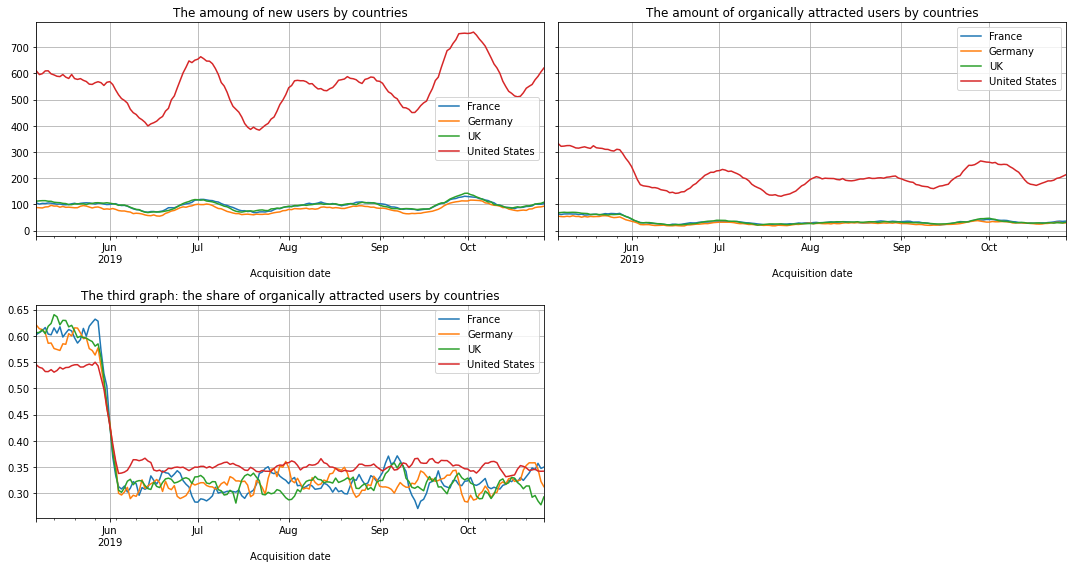

In [18]:
# setting the size of the graph
plt.figure(figsize=(15, 8))

# grouping *profiles by countries and acquisition dates
regions_dates = (
    profiles.groupby(['region', 'dt', 'channel'])
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'users_all'})
)

# counting all the attracted users
report = (
    regions_dates.groupby(['region', 'dt'])
    .agg({'users_all': 'sum'})
)

# counting organically attracted users
report_organic = (
    regions_dates.query('channel == "organic"')
    .groupby(['region', 'dt'])
    .agg({'users_all': 'sum'})
    .rename(columns={'users_all': 'users_organic'})
)

# collecting the data 
report = report.merge(report_organic, on=['region', 'dt'], how='left')
report['users_paid'] = report['users_all'] - report['users_organic']

# calculating the moving average
filtered_report = filter_data(report, 7)
date_from = date(2019, 5, 7)
filtered_report = filtered_report.query('dt >= @date_from')

# calculating the share
filtered_report['share_organic'] = filtered_report['users_organic'] / filtered_report['users_all']

# the first graph: the amoung of new users by countries
ax1=(plt.subplot(2, 2, 1))
(
    filtered_report.pivot_table(index='dt', columns='region', values='users_all', aggfunc='sum')
    .plot(grid=True, ax=ax1)
)
plt.legend()
plt.title('The amoung of new users by countries')
plt.xlabel('Acquisition date')

# the second graph: the amount of organically attracted users
ax2 = (plt.subplot(2, 2, 2, sharey=ax1))
(
    filtered_report.pivot_table(index='dt', columns='region', values='users_organic', aggfunc='sum')
    .plot(grid=True, ax=ax2)
)
plt.legend()
plt.title('The amount of organically attracted users by countries')
plt.xlabel('Acquisition date')

# the third graph: the share of organically attracted users by countries
ax3 = (plt.subplot(2, 2, 3))
(
    filtered_report.pivot_table(index='dt', columns='region', values='share_organic', aggfunc='sum')
    .plot(grid=True, ax=ax3)
)
plt.legend()
plt.title('The third graph: the share of organically attracted users by countries')
plt.xlabel('Acquisition date')

plt.tight_layout()
plt.show()

**CONCLUSIONS:**

* The share of organic users was quite high at the beginning, but dropped sharply in all countries about a month after the start of the campaign.

### Marketing

**Tasks:**

- To calculate the total cost of marketing.
- To find out how spending is distributed across advertising sources, that is, how much money was spent on each source.
- To build a visualization of the dynamics of changes in costs over time (by weeks and months) for each source.
- To find out the average cost per user acquisition (CAC) from each source.

#### Marketing expenses: general and by advertising sources

In [19]:
total_costs = costs['costs'].sum()
channels_by_costs = costs.groupby('channel').agg({'costs': 'sum'}).reset_index()
channels_by_costs['share'] = channels_by_costs['costs'] / total_costs

print('Total marketing expences: ${:.0f}'.format(total_costs))
print('')
print(channels_by_costs.sort_values('costs', ascending=False))

Total marketing expences: $105497

              channel     costs     share
6              TipTop  54751.30  0.518983
1            FaceBoom  32445.60  0.307549
7      WahooNetBanner   5151.00  0.048826
0          AdNonSense   3911.25  0.037074
4  OppleCreativeMedia   2151.25  0.020392
5      RocketSuperAds   1833.00  0.017375
2             LeapBob   1797.60  0.017039
9      lambdaMediaAds   1557.60  0.014764
3        MediaTornado    954.48  0.009047
8             YRabbit    944.22  0.008950


**CONCLUSION:**

* Over 80% of budget spent on TipTop and FaceBoom channels.

#### Looking at the dynamics of changes in expenses over time by source

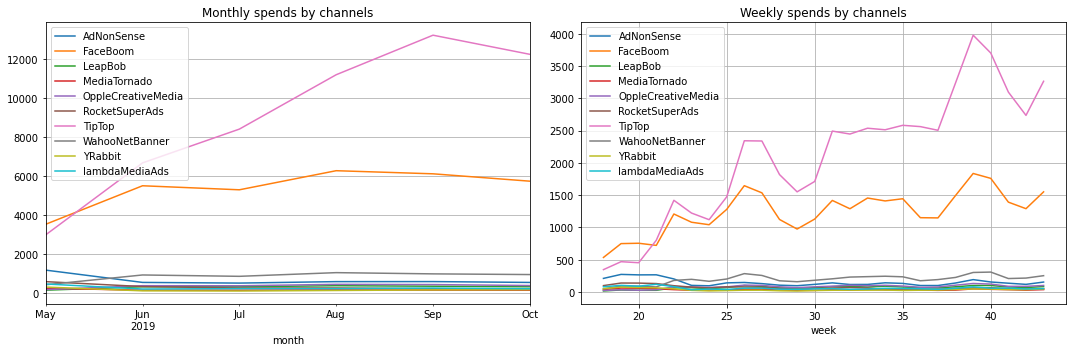

In [20]:
# setting the graph size
plt.figure(figsize=(15, 5))

# building the graph by months
(
    costs.pivot_table(index='channel', columns='month', values='costs', aggfunc='sum')
    .T.plot(grid=True, ax=plt.subplot(1, 2, 1))
)
plt.legend()
plt.title('Monthly spends by channels')

# Строим график по неделям
(
    costs.pivot_table(index='channel', columns='week', values='costs', aggfunc='sum')
    .T.plot(grid=True, ax=plt.subplot(1, 2, 2))
)
plt.legend()
plt.title('Weekly spends by channels')

plt.tight_layout()
plt.show()

**CONCLUSIONS:**

* TipTop and FaceBoom channels were the biggest spenders.
* Costs were modest at the start of the campaign but then skyrocketed, especially for the TipTop channel.

#### Looking at how much it cost on average to attract one user from each source

In [21]:
print(
    'Average cost per paid user: ${:.2f}'
    .format(profiles.query('channel != "organic"')['acquisition_cost'].mean())
)

(
    profiles.groupby('channel').agg({'acquisition_cost': 'mean'})
    .reset_index()
    .sort_values('acquisition_cost', ascending=False)
)

Average cost per paid user: $1.13


,channel,acquisition_cost
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


**CONCLUSIONS:**

* The FaceBoom channel has brought many users and has the highest conversion. But the TipTop channel has a cost of acquisition many times higher than other channels and is potentially the biggest problem.
* Also, since the beginning of the campaign, the cost of the WahooNetBanner channel has increased, which has a rather low conversion.

### Evaluation of advertising payback.

Using LTV, ROI and CAC graphs, analyze the payback of advertising. Assume that November 1, 2019 is on the calendar, and the business plan stipulates that users should pay off no later than two weeks after attracting. The need to include organic users in the analysis is determined by yourself.

**Tasks:**

- To analyze advertising payback using LTV and ROI graphs, as well as graphs of LTV, CAC and ROI dynamics.
- To check the conversion of users and the dynamics of its change. To do the same with user retention. To build and study conversion and retention charts.
- To analyze advertising ROI by device. To build LTV and ROI graphs, as well as graphs of LTV, CAC and ROI dynamics.
- To analyze advertising ROI by country. To build LTV and ROI graphs, as well as graphs of LTV, CAC and ROI dynamics.
- To analyze advertising ROI broken down by advertising channels. To build LTV and ROI graphs, as well as graphs of LTV, CAC and ROI dynamics.
- To answer the following questions:
     - Does advertising pay off in terms of user acquisition in general?
     - What devices, countries and advertising channels can have a negative impact on advertising ROI?
     - What can cause payback problems?

#### Setting the moment and the horizon for data analysis, excluding organic users

In [22]:
# the moment of the analysis is the last date in the data
observation_date = pd.to_datetime(visits['session_start']).dt.date.max()

# the horizon is 14 days
horizon_days = 14

In [23]:
# excluding organic users
profiles_paid = profiles.query('channel != "organic"')

#### LTV & ROI calculating

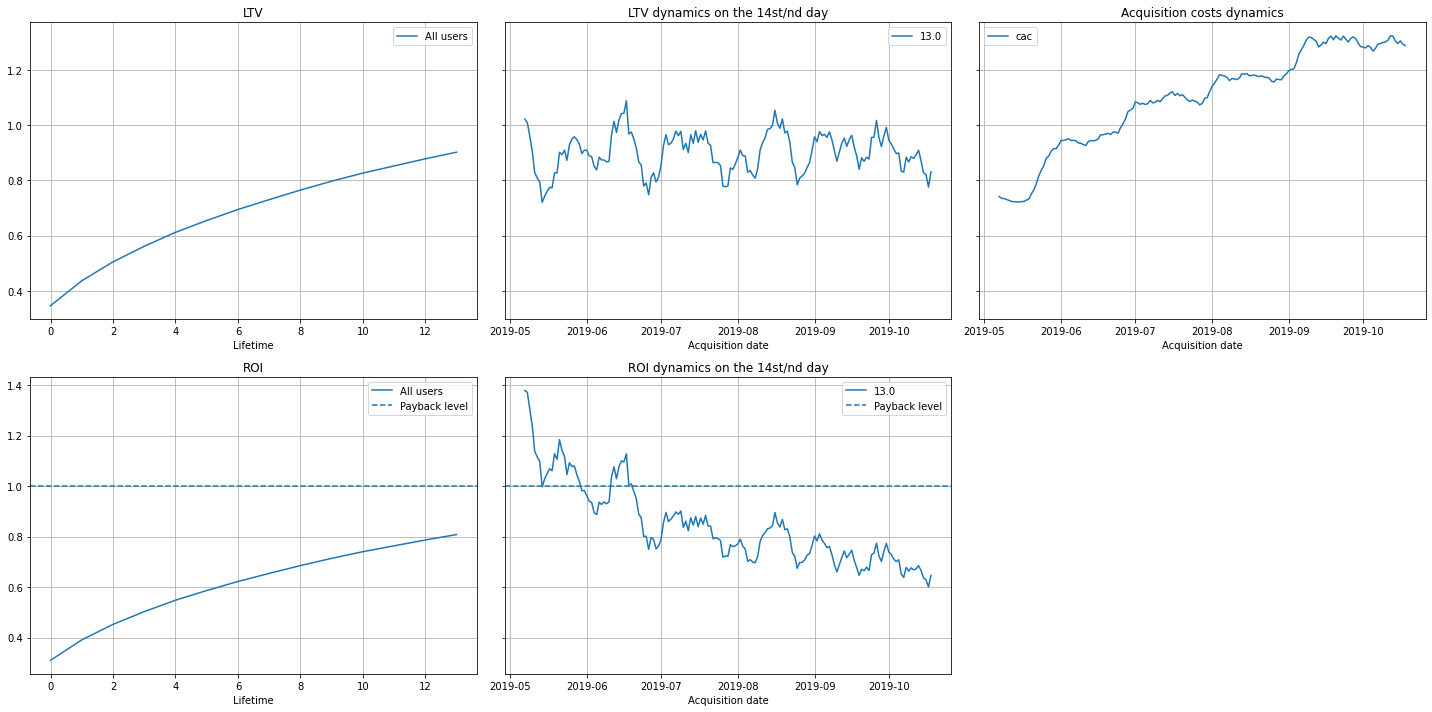

In [24]:
ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = get_ltv(
    profiles_paid, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv, ltv_dynamics, roi, roi_dynamics, horizon_days)

**CONCLUSIONS**

* In general, advertising does not pay off.
* At the beginning of the campaign, advertising paid off, but then the payback decreased.
* The cost of customer acquisition was low at the beginning of the campaign, but then it increased dramatically. At the same time, it was not possible to significantly increase LTV in order to recoup the costs.

#### Conversion calculating

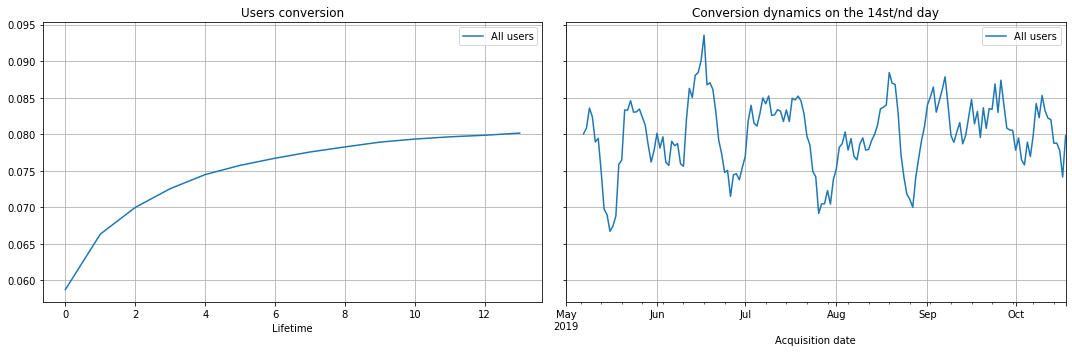

In [25]:
conversion_raw, conversion, conversion_dynamics = get_conversion(
    profiles_paid, orders, observation_date, horizon_days
)

plot_conversion(conversion, conversion_dynamics, horizon_days)

**CONCLUSIONS:**

* About 8% of users are converted to paying by the 14th day.
* Conversion fluctuates from week to week, but there is no trend (up or down).

#### Looking at total user retention

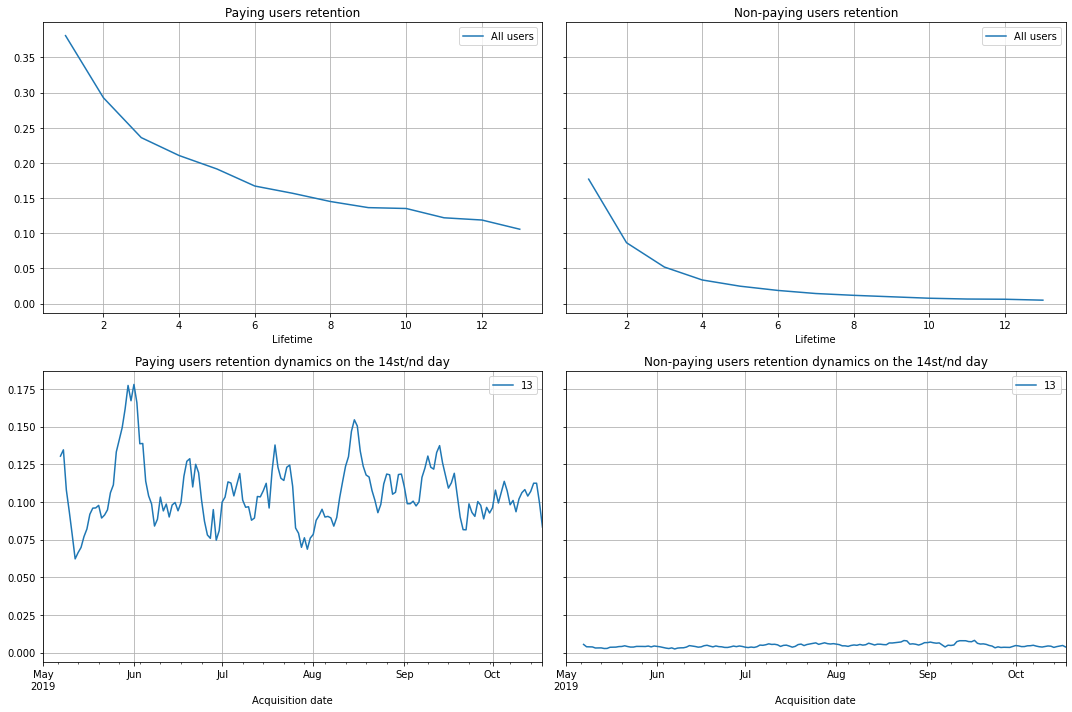

In [26]:
retention_raw, retention, retention_dynamics = get_retention(
    profiles_paid, visits, observation_date, horizon_days
)

plot_retention(retention, retention_dynamics, horizon_days)

**CONCLUSION:**

* Retention of paying users is low, just over 10% of users remaining in the app by day 14.
* Retention of non-paying users tends to zero.
* There is a minimal trend towards a decrease in the retention of paying users.

#### Looking at LTV & ROI by country

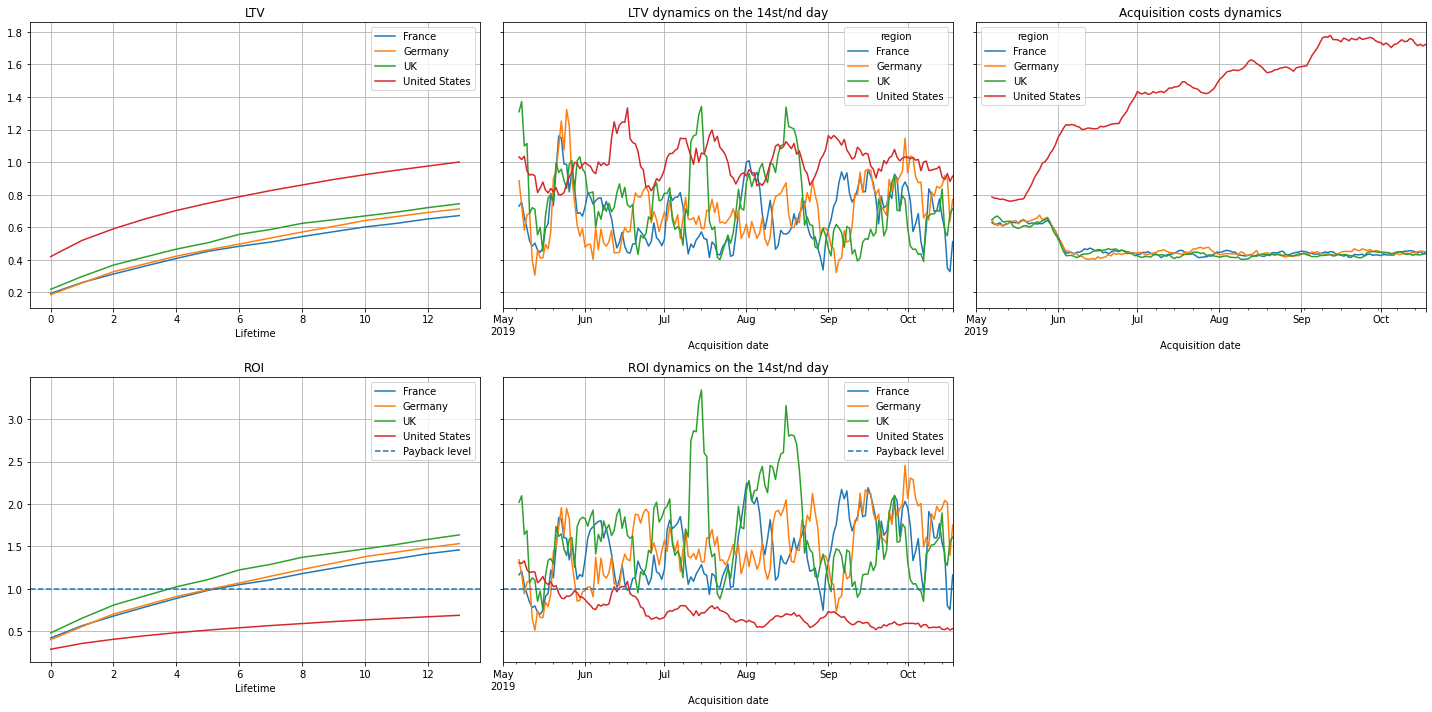

In [27]:
dimensions = ['region']

ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv, ltv_dynamics, roi, roi_dynamics, horizon_days)

**CONCLUSIONS:**

* Despite the fact that the LTV of users and the US is higher, the cost of advertising is so high that it is in the US that advertising does not pay off.
* At the start of the campaign, advertising in the US paid off, but the payback dropped as costs increased.
* In Europe, the cost of user acquisition was reduced after the first month of the campaign.
* ROI on day 14 in European countries fluctuates a lot from week to week, but does not fall.

#### Looking at LTV & ROI by device

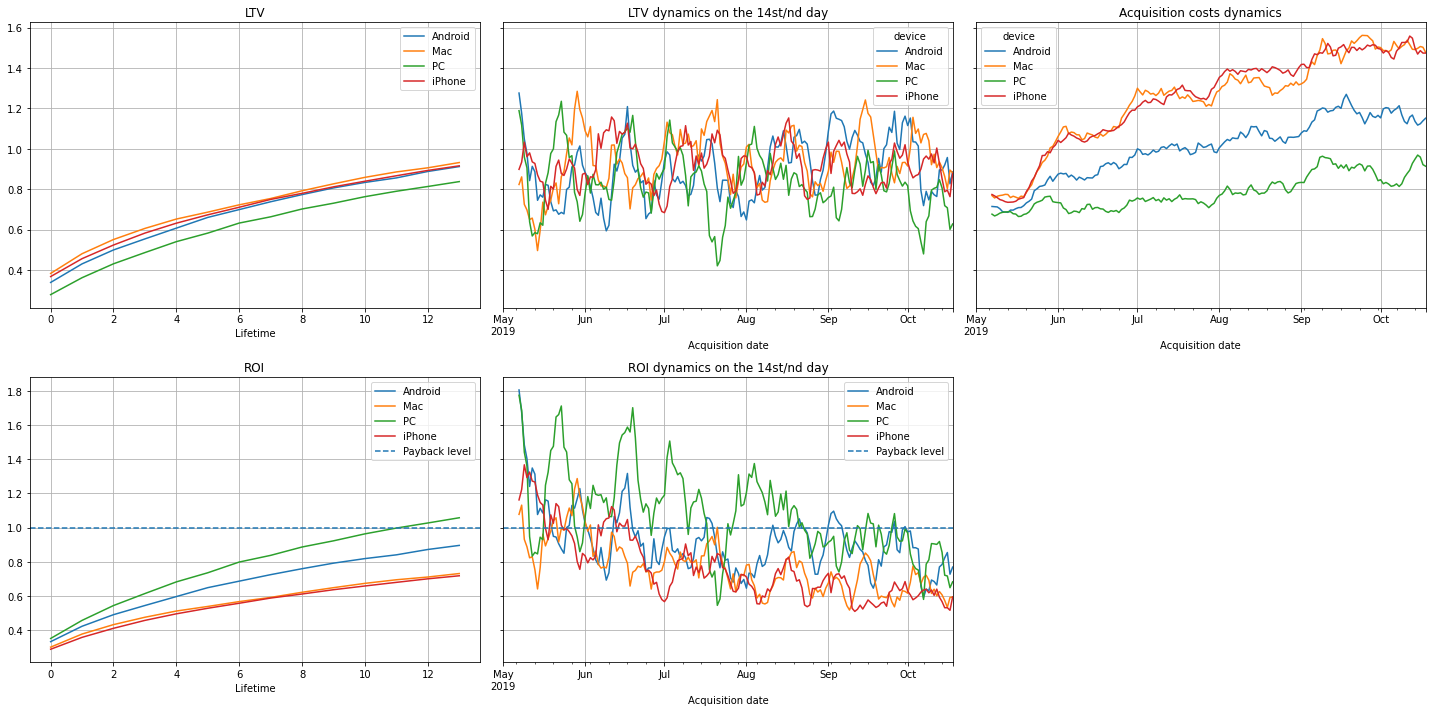

In [28]:
dimensions = ['device']

ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv, ltv_dynamics, roi, roi_dynamics, horizon_days)

**CONCLUSIONS:**

* Advertising pays off only for PC users. For iPhone and Mac users, it pays off the worst. Presumably, the fact is that more of them are in the USA.
* In general, the dynamics for all devices is similar - you can see an increase in the cost of acquisition and a decrease in ROI.

#### Looking at LTV & ROI by devices only in the USA

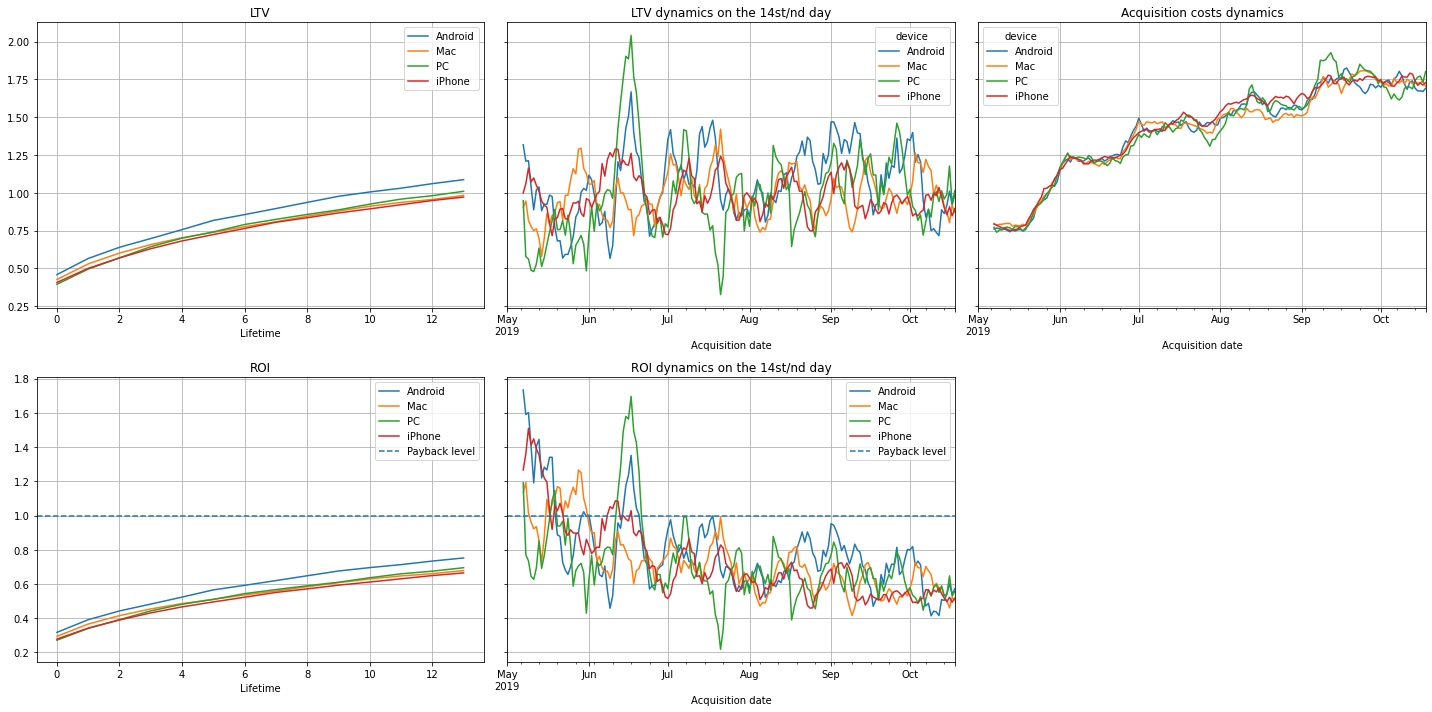

In [29]:
dimensions = ['device']

ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = get_ltv(
    profiles_paid.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv, ltv_dynamics, roi, roi_dynamics, horizon_days)

**CONCLUSIONS:**

* Android users in the US have slightly better ROI than users of other devices, but the difference is small.
* In general, the situation is similar for devices within the USA, which means that the device has almost no effect on payback.

#### Looking at LTV & ROI by channels

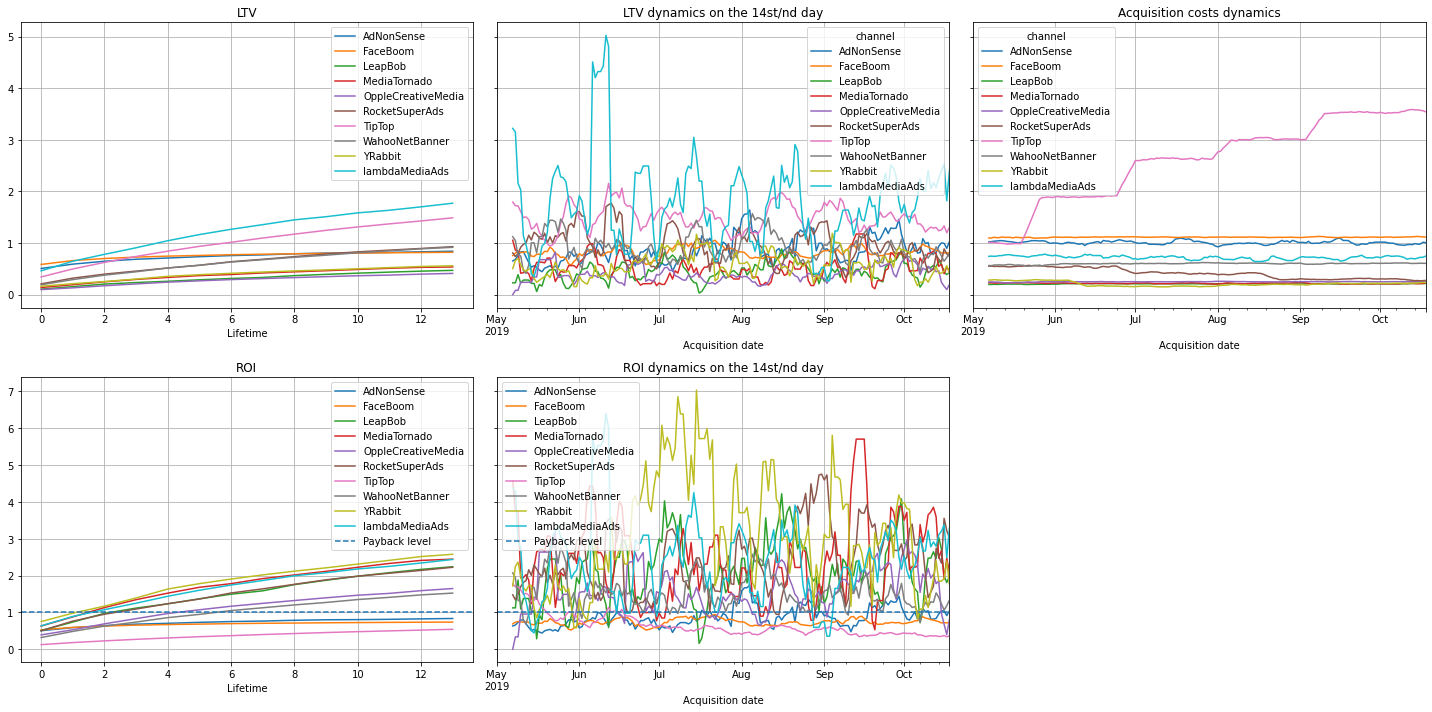

In [30]:
dimensions = ['channel']

ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv, ltv_dynamics, roi, roi_dynamics, horizon_days)

**CONCLUSIONS:**

* On the TipTop source, the cost of campaigns has increased significantly. This source gives high LTV users, but it is too expensive. It needs to be abandoned.
* AdNonSense and Faceboom sources also don't pay off, despite not seeing an increase in acquisition cost. They have good results on the first day, but almost no increase in LTV and ROI in the following days. They probably have a low retention rate. This needs to be checked.
* The highest LTV comes from lambdaMediaAds source.
* The most effective sources for payback are YRabbit, MediaTornado, lambdaMediaAds.

#### Checking LTV & ROI by channels in the USA

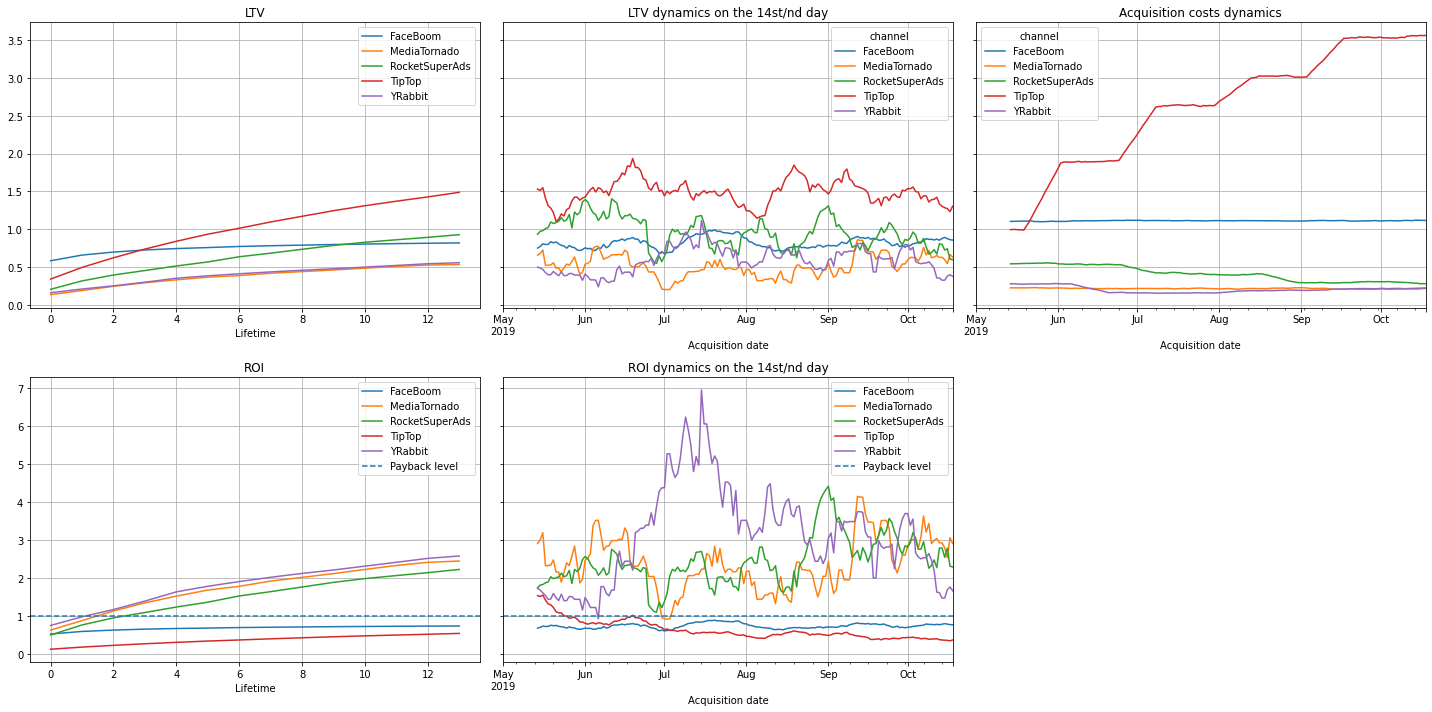

In [31]:
dimensions = ['channel']

ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = get_ltv(
    profiles_paid.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv, ltv_dynamics, roi, roi_dynamics, horizon_days, window=14)

**CONCLUSIONS:**

* FaceBoom and TipTop platforms do not pay off.
* The FaceBoom platform has a high LTV in the first three days, but then there is almost no growth.
* Other sites have a high level of payback, but their share in terms of the number of users is much smaller.

#### Checking LTV & ROI by channels in Europe

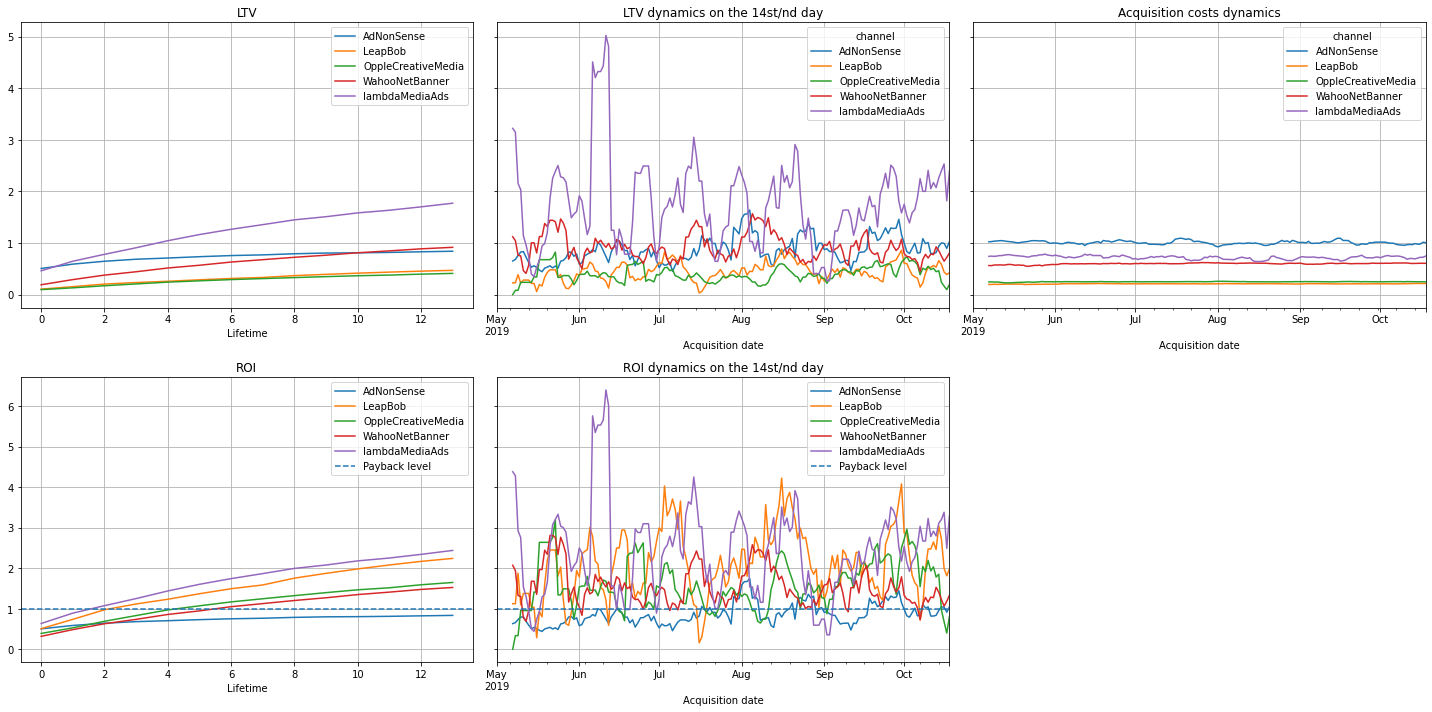

In [32]:
dimensions = ['channel']

ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = get_ltv(
    profiles_paid.query('region != "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv, ltv_dynamics, roi, roi_dynamics, horizon_days)

**CONCLUSIONS:**

* Except the AdNonSense site, all sites pay off.
* The low payback of this site is most likely due to the high cost of user acquisition and low LTV growth after the first day.
* The lambdaMediaAds platform shows a very high LTV.
* The most effective sites in terms of ROI are lambdaMediaAds and LeapBob.

#### Checking if there are any differences by country outside the problematic channels

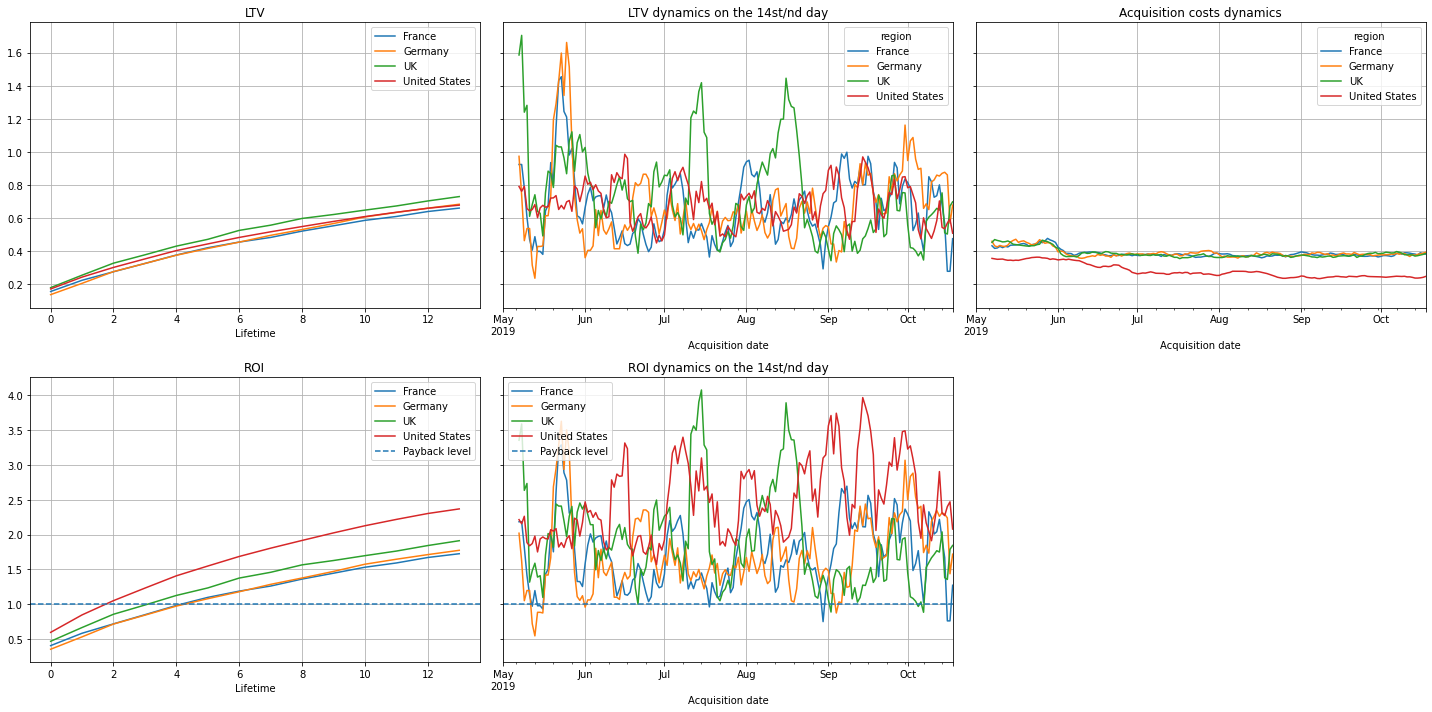

In [33]:
dimensions = ['region']

# the list of problematic channels
problem_channels = ['AdNonSense', 'TipTop', 'FaceBoom']

ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = get_ltv(
    profiles_paid.query('channel not in @problem_channels'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv, ltv_dynamics, roi, roi_dynamics, horizon_days)

**CONCLUSIONS:**

* If we exclude platforms with low ROI (AdNonSense, TipTop, FaceBoom), then in the US the cost of user acquisition is lower than in Europe, and ROI is higher.
* The inefficiency is caused precisely by specific sites, and not by host countries.
* The cost of attracting users on effective sites was higher in the first month

#### Looking at the conversion by channels

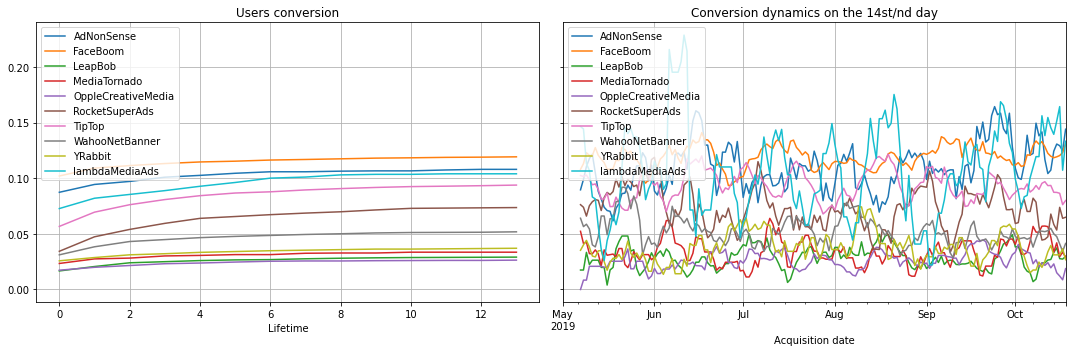

In [34]:
dimensions=['channel']

conversion_raw, conversion, conversion_dynamics = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion, conversion_dynamics, horizon_days)

**CONCLUSIONS:**

* Users from problematic sources convert well.
* In general, the increase in conversion from day to day is quite small: from a number of sites, the conversion almost does not grow after 1-2 days.

#### Looking at the conversion by countries

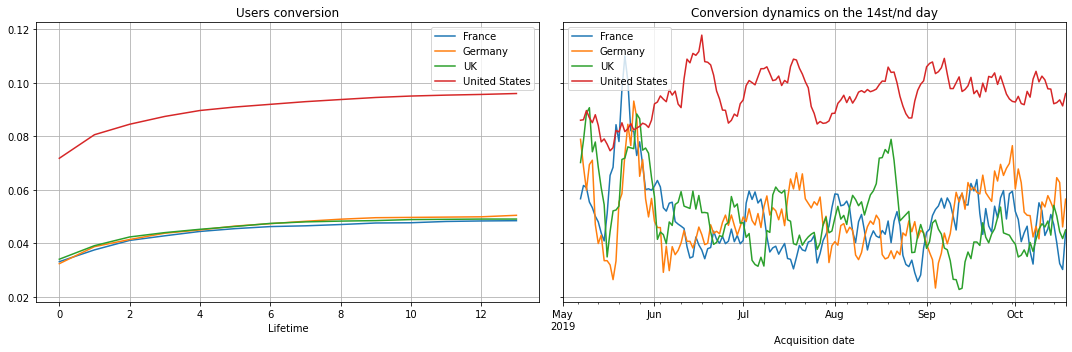

In [35]:
dimensions=['region']

conversion_raw, conversion, conversion_dynamics = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion, conversion_dynamics, horizon_days)

**CONCLUSIONS:**
* Conversion in the US is significantly higher than in Europe. This means that the US has a lot of potential, unless the cost of user acquisition is too high.
* There is no significant difference in conversion between European countries.

#### Looking at the conversion by devices

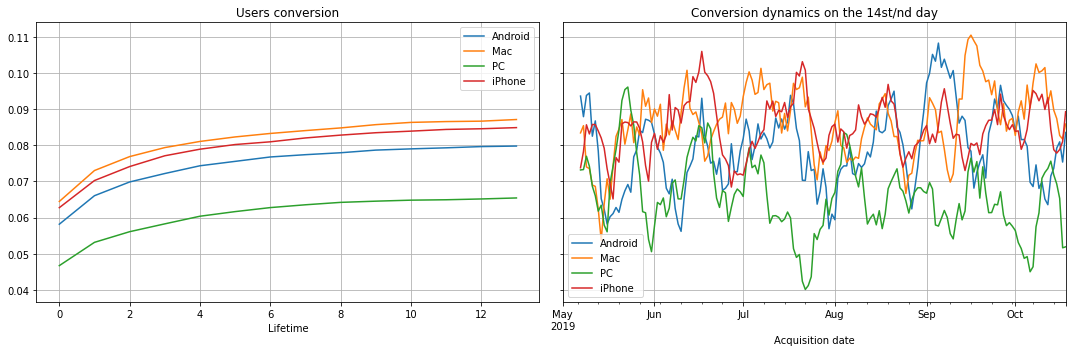

In [36]:
dimensions=['device']

conversion_raw, conversion, conversion_dynamics = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion, conversion_dynamics, horizon_days)

**CONCLUSIONS:**

* Highest conversion on Mac and iPhone, lowest is on PC.
* Differences in device conversions may be caused by country. To check this, we need to look at devices within the same country.

#### Looking at the conversion by device only in the USA

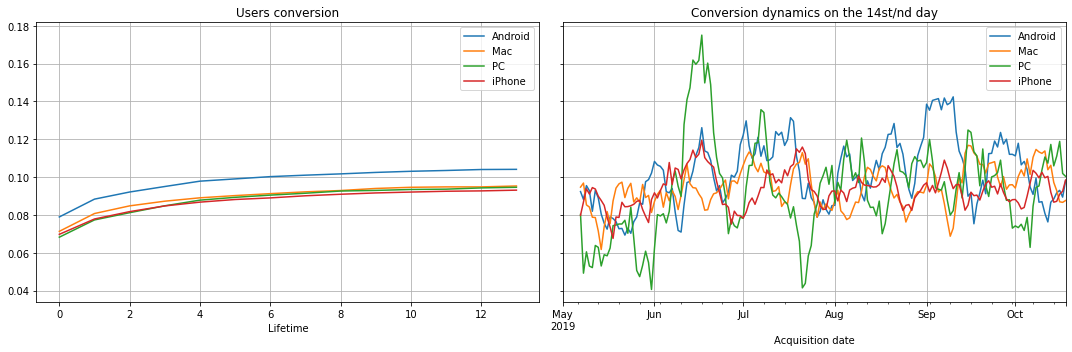

In [37]:
dimensions=['device']

conversion_raw, conversion, conversion_dynamics = get_conversion(
    profiles_paid.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion, conversion_dynamics, horizon_days)

**CONCLUSION:**

* The best conversion is on Android devices which correlates with ROI charts.

#### Looking at the retention by source

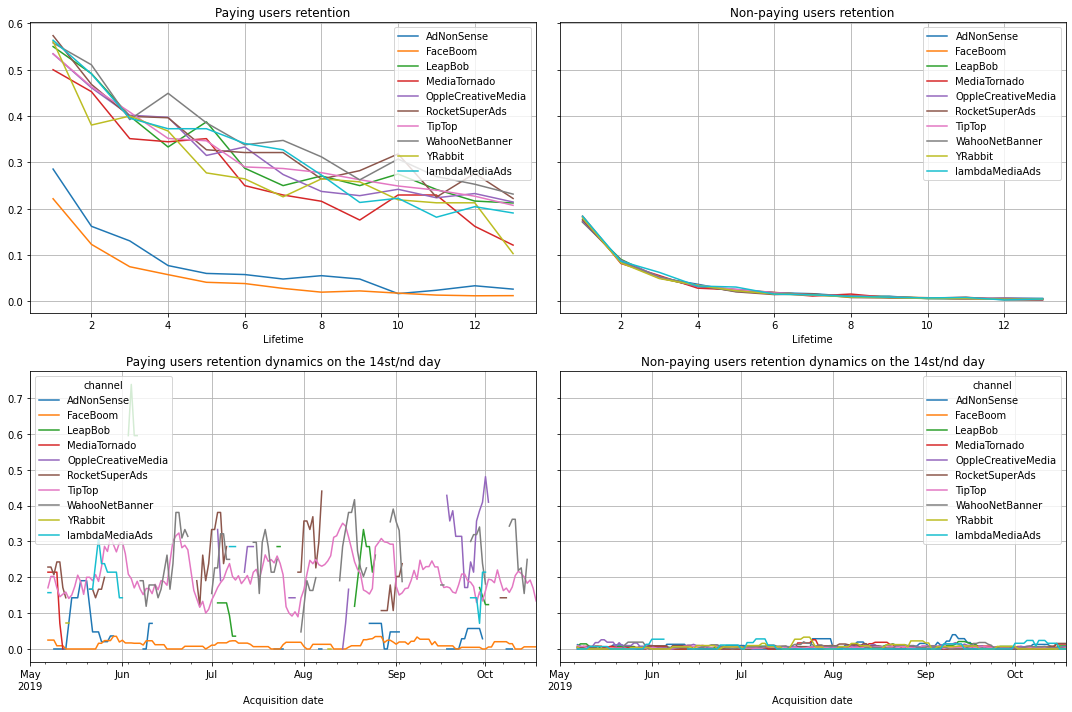

In [38]:
dimensions=['channel']

retention_raw, retention, retention_dynamics = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention, retention_dynamics, horizon_days)

**CONCLUSIONS:**

* Users from the FaceBoom and AdNonSense channels have very low retention rates with high conversions. Perhaps advertising offers them interesting functionality in the first days for money or discounts. Or maybe ads create high expectations. Then the app doesn't live up to those expectations or the special functionality stops and users leave.
* Retention of non-paying users from all channels tends to zero - the free version of the application is not very interesting for users.

#### Looking at the retention by country

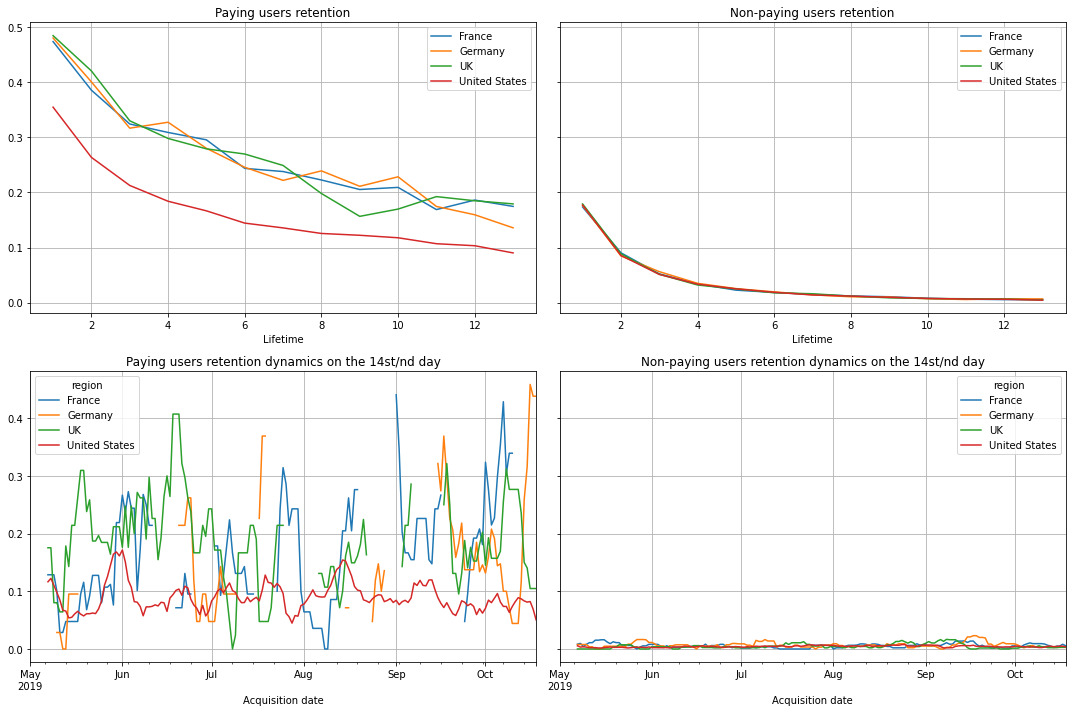

In [39]:
dimensions=['region']

retention_raw, retention, retention_dynamics = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention, retention_dynamics, horizon_days)

**CONCLUSION:**

* Retention in the US is lower than in Europe. Perhaps it's the problematic FaceBoom channel. This needs to be checked.

#### Looking at the retention by country, but without problematic channels

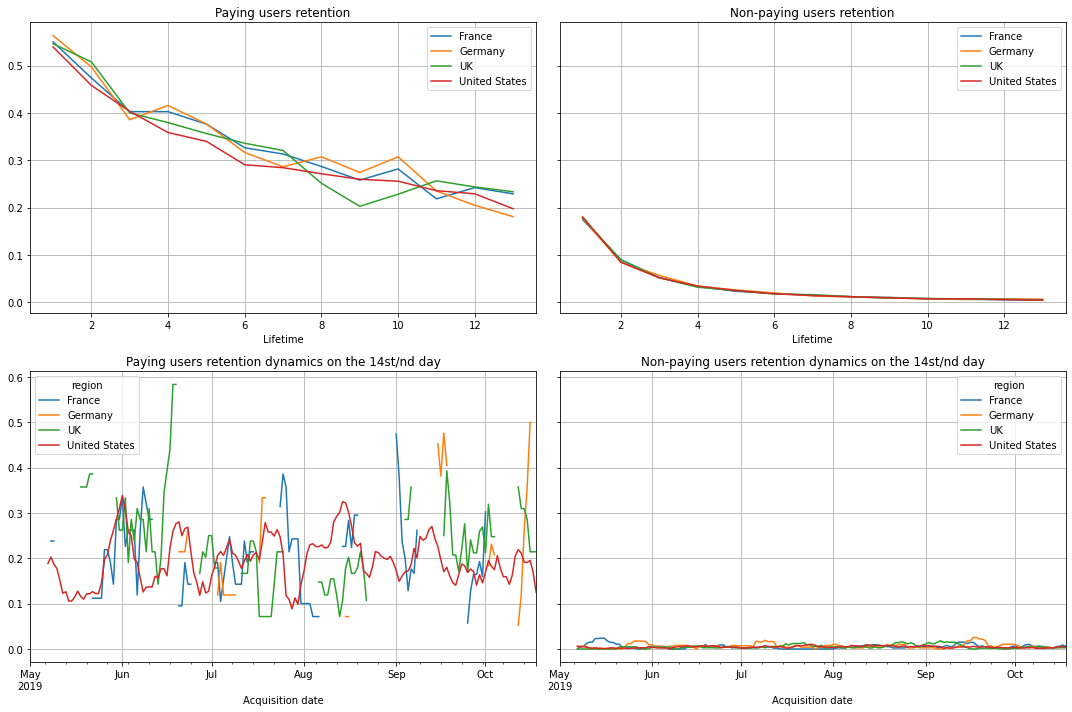

In [40]:
dimensions=['region']

# Список проблемных площадок
problem_channels = ['AdNonSense', 'FaceBoom']

retention_raw, retention, retention_dynamics = get_retention(
    profiles_paid.query('channel not in @problem_channels'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention, retention_dynamics, horizon_days)

**CONCLUSION:**

* Retention in all countries excluding channels with extremely low retention is comparable. This means that the country itself does not affect retention.

#### Looking at the retention by device

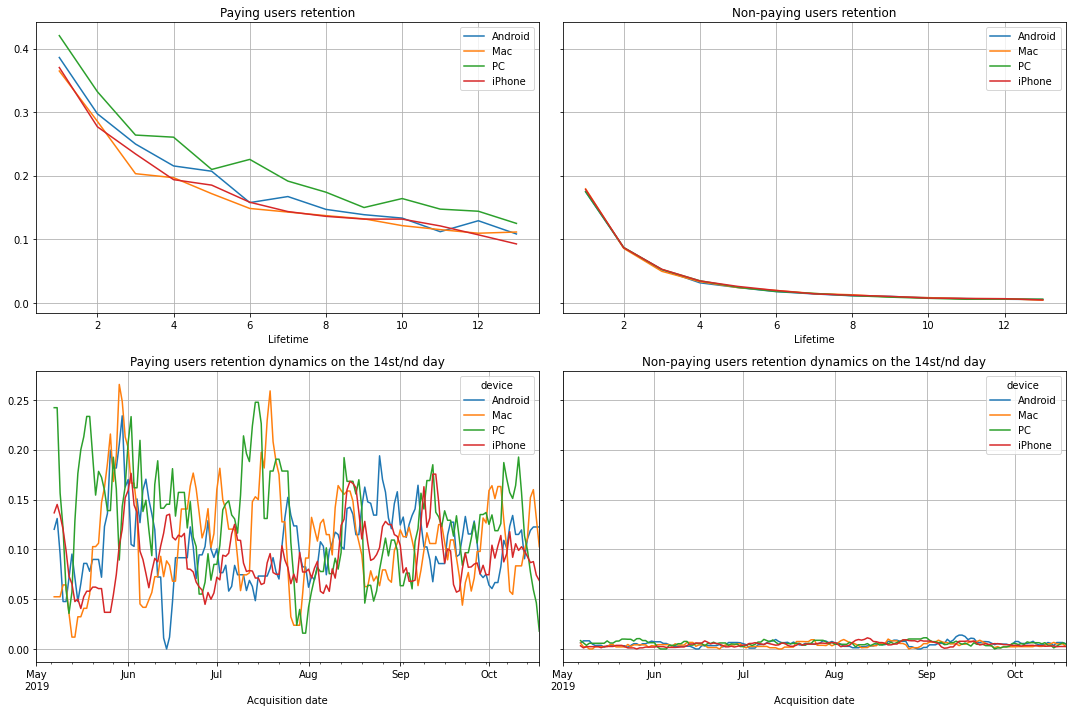

In [41]:
dimensions=['device']

retention_raw, retention, retention_dynamics = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention, retention_dynamics, horizon_days)

**CONCLUSION:**

* Retention of paying users is slightly higher on PC.

#### Looking at the retention by device, but without problematic channels

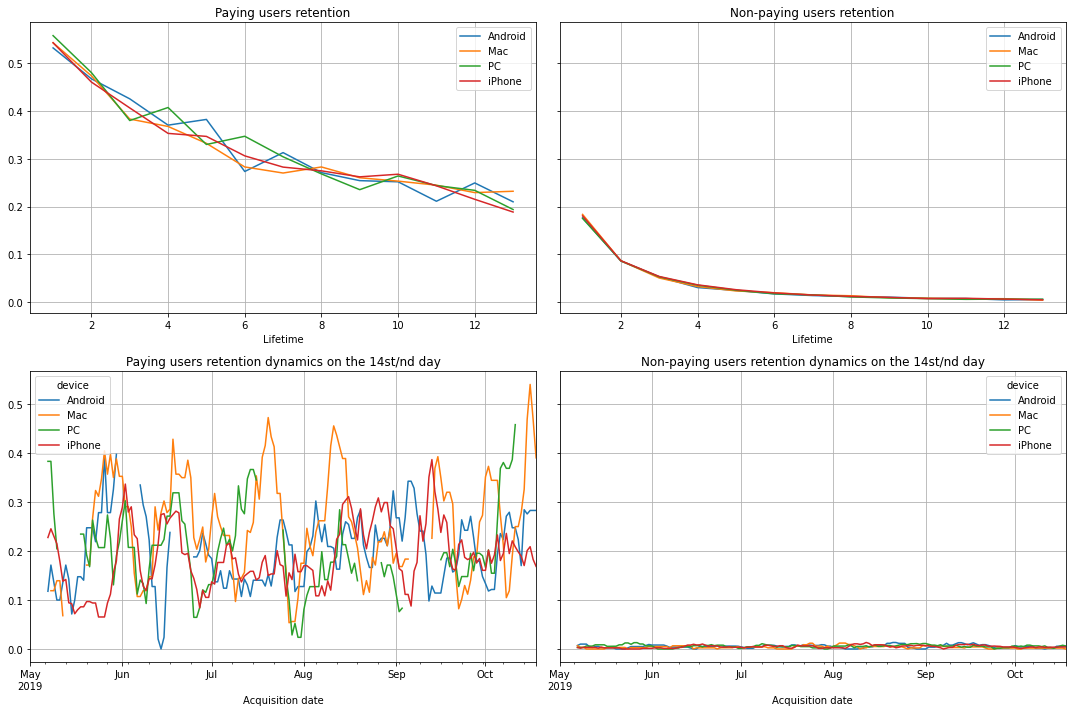

In [42]:
dimensions=['device']

# Список проблемных площадок
problem_channels = ['AdNonSense', 'FaceBoom']

retention_raw, retention, retention_dynamics = get_retention(
    profiles_paid.query('channel not in @problem_channels'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention, retention_dynamics, horizon_days)

**CONCLUSION:**

* There are no significant differences in retention across devices.

### Conclusions

**CONCLUSIONS:**

1. Two-thirds of users and three-quarters of paying users are from the US. The US has the highest percentage of paying users.
1. In general, advertising aimed at attracting users does not pay off.
1. TipTop and FaceBoom spent the most money. Spending was modest at the start of the campaign, but then skyrocketed, especially for the TipTop channel.
1. Countries and devices do not fundamentally affect the effectiveness of user acquisition.
1. User retention is very low. Less than 15% of paying users stay in the app by 14th day. Retention of non-paying users on the 14th day is almost zero.
1. The problem is in three channels of acquisition that negatively affect the results:
     1. TipTop (USA). This channel has a very high user acquisition cost. At the start of the campaign, the results were good, but over the course of the campaign, the cost of attraction increased significantly. At the same time, the volume of costs has grown significantly, which is why the influence of this channel on the campaign as a whole has increased. Probably, the costs increased due to the fact that the channel attracted a lot of users and showed a good conversion rate. At the same time, we did not control the increase in the price for attracting a user.
     1. FaceBoom (USA). This channel has a fairly high cost and a very low retention rate. Perhaps some promotions are offered through this channel for new users, users come in, make a purchase, but then leave the appl. Because of this, the channel has a good ROI on the first day, but it almost does not grow in the following days. At the same time, the most users were attracted through this channel, and the channel showed the highest conversion. Perhaps because of this, it was decided to increase the budget for this channel.
     1. AdNonSense (Europe). This channel also has a high cost and a low retention rate. Like the FaceBoom channel, it has a good ROI on the first day, but it hardly grows in the following days. The channel showed the best conversion in Europe, but due to low retention, it does not pay off.
1. The most effective sources for payback are YRabbit, MediaTornado, lambdaMediaAds. At the same time, YRabbit and MediaTornado have low conversion rates.
1. The RocketSuperAds source is the best in the USA in terms of the sum of all factors: it has a fairly high conversion rate and at the same time is inexpensive, which also gives a good payback.
1. Source WahooNetBanner also has a good ROI with an average conversion, but is inferior to the best source in Europe - lambdaMediaAds.
1. Conversion on Android devices is slightly higher than on others.

**RECOMMENDATIONS:**

1. Find out the reasons for the low retention rate of users from the FaceBoom and AdNonSense channels. Try to increase the retention rate, bring it to the level of other channels. It may be worth offering these users favorable conditions a few days after the first visit so that they return. It's also possible that ads on these channels create very high expectations that cause users to leave. If you can't improve retention, stop advertising on these channels.
1. Exclude the TipTop channel if you can't get your cost per acquisition down.
1. In the future, monitor the dynamics of the cost of user acquisition by channel. The cost on a particular channel can skyrocket and make placement on that channel ineffective.
1. When choosing channels where you can increase your advertising budget, you need to focus on all the indicators in the complex, and not just on individual ones, for example, high conversion.
1. Increase the budget on the lambdaMediaAds and RocketSuperAds channels, if possible without increasing the cost. You can also use the WahooNetBanner channel more actively.
1. Explore why Android conversions are higher than other devices. It may be more convenient to pay on Android devices. Then you need to work on the convenience of paying from other devices.
1. Understand if it is possible to increase the retention of non-paying users so that they have a chance to convert to paying users in the future. It might be worth adding a few free features.